In [53]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd
from IPython.display import display, HTML
from scipy import stats
import matplotlib.ticker as ticker
def load_json(file_path): # Load JSON Data
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            try:
                return json.load(f)
            except json.JSONDecodeError:
                print("JSON decode error — file is empty or malformed.")
                return {}
    else:
        return {}  # Return empty dict if file doesn't exist


def update_json(data, key, value): # Modify/Add Data
    data[key] = value
    return data

def save_json(file_path, data): # Save JSON Data
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)
def split_phase_and_spacegroup(phase_str):
    """
    Splits a phase string like 'VO2_14' into phase name and space group.
    Returns (phase_name, space_group) as strings.
    """
    if "_" in phase_str:
        phase_name, space_group = phase_str.rsplit("_", 1)
        return phase_name, space_group
    else:
        return phase_str, None
def interpret_dict_list(run_interpretations): 
    """
    interprets a dictionary and returns a new dictionary 
    with lists of phases for each interpretation
    """
    interpret_dict = {}  # Dictionary to hold interpretations and their phases in correct format
    for interpret in run_interpretations: # iterate over each interpretation in the run
        if interpret.startswith("I_"):  # Check if the key starts with "I_"
            # Extract the interpretation number and phases
            interpret_dict[interpret] = []  # Initialize an empty list for this interpretation
            for i in range(len(run_interpretations[interpret]["phases"])):
                phase_str = run_interpretations[interpret]["phases"][i] # e.g., "ZrTiO4_18"
                phase_name, space_group = split_phase_and_spacegroup(phase_str) #splits string into phase name and space group 
                wf = int(round(run_interpretations[interpret]["weight_fraction"][i])) # get the weight fraction and round so there is no decimal
                written_phase = f"{phase_name} (space group {space_group}, weight fraction {wf}%)"
                interpret_dict[interpret].append(written_phase)
    return interpret_dict

def phase_key_to_short(phase_key):
    """
    Convert 'VO2 (space group 14)' to 'VO2_14'
    """
    if " (space group " in phase_key and phase_key.endswith(")"):
        name, sg = phase_key.split(" (space group ")
        sg = sg.rstrip(")")
        return f"{name} ({sg})"
    return phase_key

In [93]:
def interpretation_comparison_graph(json_file_path,Interpretation):
    """ 
    takes in a json_file_path and a string "I_#" for the specific interpretation and graphs a side by side comparison
    of the Chat GPT and Llama interpretation likelihoods
    """
    Run_name_1 = []
    ChatGpt_1 = []
    llama_1 = []
    json_file = load_json(json_file_path)
    for run in json_file:
        if "Synth_Conditions" in json_file[run]:
            if (
                "LLM_interpretation_likelihood" in json_file[run].get(Interpretation, {}) and
                "LLM_interpretation_likelihood_llama" in json_file[run].get(Interpretation, {})
            ):
                chatgpt_val = json_file[run][Interpretation]["LLM_interpretation_likelihood"]
                llama_val = json_file[run][Interpretation]["LLM_interpretation_likelihood_llama"]
                if chatgpt_val is not None and llama_val is not None:
                    try:
                        ChatGpt_1.append(float(chatgpt_val))
                        llama_1.append(float(llama_val))
                        Run_name_1.append(run)
                    except ValueError:
                        print(f"Non-numeric value in run {run}: {chatgpt_val}, {llama_val}")

    x1 = np.arange(len(Run_name_1))
    width = 0.35
    
    fig1, ax1 = plt.subplots(figsize=(16,6))
    rects1 = ax1.bar(x1 - width/2, ChatGpt_1, width, label='Chat GPT')
    rects2 = ax1.bar(x1 + width/2, llama_1, width, label='llama')
    for j, val in enumerate(ChatGpt_1):
        ax1.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8, rotation=0, clip_on=True)
    for j, val in enumerate(llama_1):
        ax1.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=8, rotation=0, clip_on=True)
    ax1.set_ylabel('Interpretation Likelihood')
    ax1.set_title(f'LLM Interpretation Likelihood by Run ({Interpretation})')
    ax1.set_xticks(x1)
    ax1.set_xticklabels(Run_name_1)
    ax1.legend()
    plt.show()

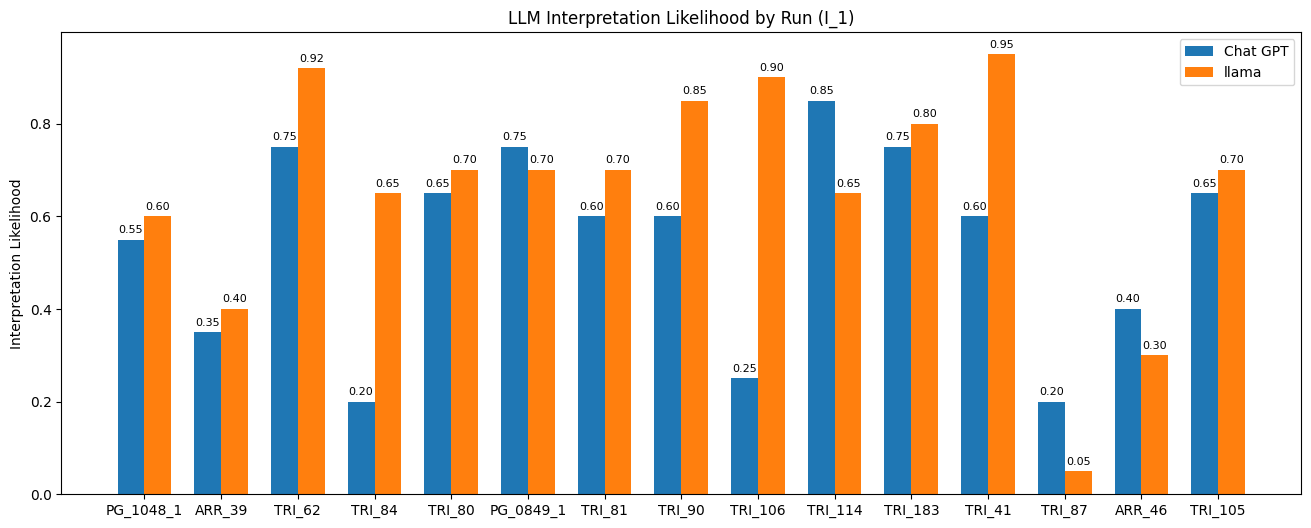

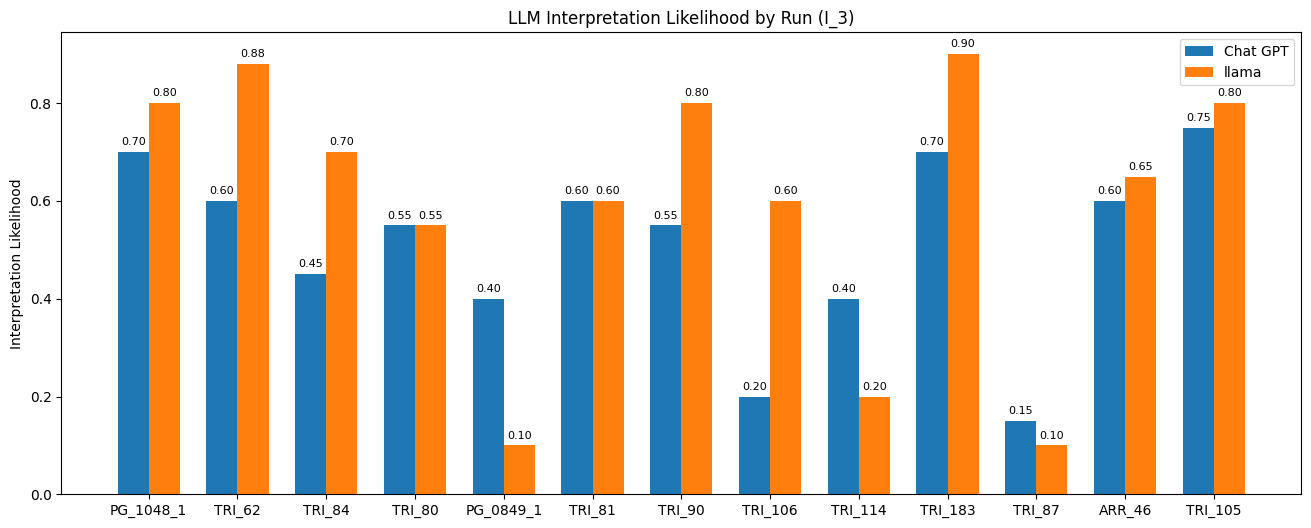

In [94]:
json_file_path = "../Data/prompt3/interpretations_llm_v1_llama1.json"
interpretation_A = "I_1"
interpretation_B = "I_3"
interpretation_comparison_graph(json_file_path,interpretation_A)
interpretation_comparison_graph(json_file_path,interpretation_B)


In [92]:
def graph_onesample_interpretations(json_file_path,run):
    """ 
    takes in a json_file_path and a run (sample name) and can output a graph of all 
    interpretation likelihoods and the explanations for each rating 
    """
    json_file = load_json(json_file_path)
    Interpretation = []
    ChatGpt_1 = []
    llama_1 = []
    for interpret in json_file[run]:
        if interpret not in ["Synth_Conditions"]:
            chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
            chatgpt_exp = json_file[run][interpret].get("LLM_interpretation_explanation")
            llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
            llama_exp = json_file[run][interpret].get("LLM_interpretation_explanation_llama")
            #print out the scores and explanations for each interpretation
            print(f"{interpret}: ChatGPT: {chatgpt_val} - {chatgpt_exp}")
            print(f"{interpret}: llama: {llama_val} - {llama_exp}") 
            

            if chatgpt_val is not None and llama_val is not None:
                try:
                    ChatGpt_1.append(float(chatgpt_val))
                    llama_1.append(float(llama_val))
                    Interpretation.append(interpret)
                except ValueError:
                    print(f"Non-numeric value in run {run}, interpretation {interpret}: {chatgpt_val}, {llama_val}")
    synth = json_file[run]["Synth_Conditions"]
    if "Precursor 3" in synth:
        input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'
    else: 
        input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}'


    x1 = np.arange(len(Interpretation))
    width = 0.35

    plt.figure(figsize=(16,5))
    plt.bar(x1 - width/2, ChatGpt_1, width, label='Chat GPT')
    plt.bar(x1 + width/2, llama_1, width, label='llama')
    plt.ylabel('Interpretation Likelihood')
    plt.title(f'LLM Interpretation Likelihood by Interpretation (Run {run})\nPrecursors: {input_phases}')
    plt.xticks(x1,Interpretation, rotation=0, ha='center')
    for j, val in enumerate(ChatGpt_1):
        plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    for j, val in enumerate(llama_1):
        plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    plt.ylim(0,1.1)
    plt.legend()
    plt.tight_layout
    plt.show()

I_1: ChatGPT: 0.2 - The interpretation suggests a single phase that is not aligned with the target composition or expected phases under the given conditions. The composition balance score is high, but the phase itself is unlikely to form, reducing the overall plausibility.
I_1: llama: 0.65 - The interpretation seems plausible with a mix of vanadate phases. However, V₂O₅ presence in significant amounts is questionable under Argon atmosphere unless it forms during post-synthesis exposure to air.
I_2: ChatGPT: 0.5 - This interpretation includes a mix of plausible and less likely phases. The presence of V2O5 is reasonable, but the complex K10V21O57 phase and KV3O8 reduce the overall likelihood. The composition balance is moderate, reflecting the mixed plausibility of the phases.
I_2: llama: 0.5 - The presence of multiple phases including less common K₁₀V₂₁O₅₇ and significant V₂O₅ makes this interpretation less likely due to redox inconsistencies and phase stability.
I_3: ChatGPT: 0.45 - Th

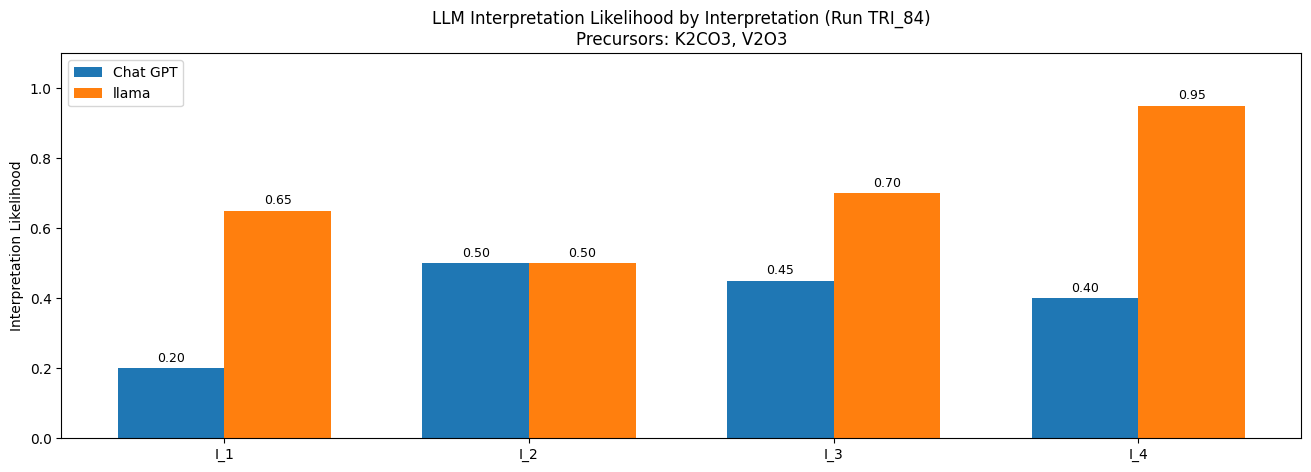

In [67]:
sample = "TRI_84"
json_file_path = "../Data/prompt3/interpretations_llm_v1_llama1.json"
graph_onesample_interpretations(json_file_path,sample)

In [ ]:
def chart_notable_interpretations(json_file_path,bigDiff=0.30,littleDiff=0.10):
    """ 
    Outputs three seperate data frames
    1. any interpretations where the likelihoods differed by more than bigDiff
    2. any interpretations where llama returned a zero likelihood
    3. any interpretations with a likelihood difference of less than littleDiff (to see what is working well)
    could also be adjusted for any two different runs or models 
    """
    json_file = load_json(json_file_path)

    rows_sig_diff = []
    rows_llama_zero = []
    rows_little_diff = []
    # Collect runs and interpretations where the difference between LLMs is significant or llama likelihood is zero or little difference

    for run in json_file: 
        if "Synth_Conditions" in json_file[run]:
            for interpret in json_file[run]:
                if interpret != "Synth_Conditions":
                    chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
                    chatgpt_exp = json_file[run][interpret].get("LLM_interpretation_explanation")
                    llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
                    llama_exp = json_file[run][interpret].get("LLM_interpretation_explanation_llama")
                    diff = chatgpt_val - llama_val
                    synth_conditions = json_file[run].get("Synth_Conditions")
                    sythCon = (
                        f"Target: {synth_conditions.get('Target', '')}<br>"
                        f"Precursors:{synth_conditions.get('Precursor 1', '')},{synth_conditions.get('Precursor 2', '')},{synth_conditions.get('Precursor 3', '')}<br>"
                        f"Furnace:{synth_conditions.get('Furnace', '')}<br>"
                        f"Temperature:{synth_conditions.get('Temperature (C)', '')} C<br>"
                        f"Dwell Duration:{synth_conditions.get('Dwell Duration (h)', '')}"
                    )
                    phases = interpret_dict_list(json_file[run])
                    phases = phases.get(interpret, [])  # Get the list of phases for this interpretation
                    phases = ", ".join(phases) # gets rid of brackets 
                    bigDiff_buffer = bigDiff + 1e-8
                    if abs(diff) > bigDiff_buffer: # select out runs+interpretations where the difference between LLMs is greater than eg. 0.30 (could change this threshold)
                        rows_sig_diff.append({
                            "Difference >0.30": f"{run} {interpret}",
                            "Difference (Gpt-llama)": diff,
                            "ChatGPT Likelihood": chatgpt_val,
                            "Llama Likelihood": llama_val,
                            "Synth Conditions": sythCon,
                            "Interpretation Phases": phases,
                            "ChatGPT Explanation": chatgpt_exp,
                            "Llama Explanation": llama_exp,
                        })
                    if llama_val == 0.0: # select out runs+interpretaions where llama likelihood is zero 
                        rows_llama_zero.append({
                            "Llama reported likelihood as zero": f"{run} {interpret}",
                            "Difference (Gpt-llama)": diff,
                            "ChatGPT Likelihood": chatgpt_val,
                            "Llama Likelihood": llama_val,
                            "Synth Conditions": sythCon,
                            "Interpretation Phases": phases,
                            "ChatGPT Explanation": chatgpt_exp,
                            "Llama Explanation": llama_exp,
                        })
                    if abs(diff) < littleDiff:
                        rows_little_diff.append({
                            "Difference was less than 0.10": f"{run} {interpret}",
                            "Difference (Gpt-llama)": diff,
                            "ChatGPT Likelihood": chatgpt_val,
                            "Llama Likelihood": llama_val,
                            "Synth Conditions": sythCon,
                            "Interpretation Phases": phases,
                            "ChatGPT Explanation": chatgpt_exp,
                            "Llama Explanation": llama_exp,
                        })


    df_sig_diff = pd.DataFrame(rows_sig_diff) #convert to dataframes
    df_sig_diff = df_sig_diff.sort_values(by="Difference (Gpt-llama)", ascending=False)
    df_llama_zero = pd.DataFrame(rows_llama_zero)
    df_little_diff = pd.DataFrame(rows_little_diff) 
    df_little_diff = df_little_diff.sort_values(by="Difference (Gpt-llama)", ascending=False)



    # Set display options for line breaks 
    pd.set_option('display.max_colwidth', None)
    display(HTML("<style>pre {white-space: pre-wrap;}</style>"))

    # Display DataFrames
    display(HTML(df_sig_diff.to_html(escape=False)))
    display(HTML(df_llama_zero.to_html(escape=False)))
    display(HTML(df_little_diff.to_html(escape=False)))

    # Save DataFrames to CSV files (Comment out if not needed)
    # df_sig_diff.to_csv("Data/sig_diff.csv", index=False)
    # df_llama_zero.to_csv("Data/llama_zero.csv", index=False)
    # df_little_diff.to_csv("Data/little_diff.csv", index=False)

In [ ]:
sample = "TRI_84"
json_file_path = "../Data/prompt3/interpretations_llm_v1_llama1.json"
# chart_notable_interpretations(json_file_path) # Long Data Frame, so I commented out

In [ ]:
def likelihood_difference_histogram(json_file_path):
    """ 
    Takes in a json_file_path and outputs a histogram of interpretation likelihood differences comparing llama and chat gpt
    can also be used to compare two runs of the same LLM for consistency
    """
     # Define bin edges for every 0.01 from -1 to 1
    json_file = load_json(json_file_path)
    # Collect all differences in a list
    over_30 = 0
    range15_30 = 0
    range0_15 = 0
    neg15_0 = 0
    neg30_neg15 = 0
    over_neg30 = 0
    total_interpretations = 0
    total_runs = 0
    total_phases = 0
    # === Main Code Graph 3 ===
    for run in json_file: 
        if "Synth_Conditions" in json_file[run]:
            has_interpretation = any(k.startswith("I_") for k in json_file[run].keys())
            if has_interpretation:
                total_runs += 1
            for interpret in json_file[run]:
                if interpret != "Synth_Conditions":
                    total_interpretations += 1
                    chatgpt_phases = json_file[run][interpret].get("LLM_phases_likelihood")
                    llama_phases = json_file[run][interpret].get("LLM_phases_likelihood_llama")
                    for phase in chatgpt_phases:
                        if phase in llama_phases:
                            chatgpt_val = chatgpt_phases[phase]
                            llama_val = llama_phases[phase]
                            diff = chatgpt_val - llama_val
                            # Count the differences in bins
                            if diff > .30:
                                over_30 += 1
                            elif .15 < diff <= .30:
                                range15_30 += 1
                            elif 0 < diff <= .20:
                                range0_15 += 1
                            elif -.15 < diff <= 0:
                                neg15_0 += 1
                            elif -.30 < diff <= -.20:
                                neg30_neg15 += 1
                            elif -.30 < diff:
                                over_neg30 += 1
                            total_phases += 1
    diffs = []
    for run in json_file:
        if "Synth_Conditions" in json_file[run]:
            for interpret in json_file[run]:
                if interpret != "Synth_Conditions":
                    chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
                    llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
                    if chatgpt_val is not None and llama_val is not None:
                        diffs.append(chatgpt_val - llama_val)

    # Define bin edges for every 0.01 from -1 to 1 (adjust range as needed)
    bins = np.arange(-1, 1, 0.01)

    # Calculate statistics if diffs is not empty
    if diffs:  # Check if list is not empty
        diffs_np = np.array(diffs)
        mean = np.mean(diffs_np)
        std = np.std(diffs_np)
        median = np.median(diffs_np)
        min_val = np.min(diffs_np)
        max_val = np.max(diffs_np)
        q25 = np.percentile(diffs_np, 25)
        q75 = np.percentile(diffs_np, 75)
        skew = stats.skew(diffs_np)
        kurtosis = stats.kurtosis(diffs_np)
        stats_text = (
            f"Mean: {mean:.4f}\n"
            f"Std: {std:.4f}\n"
            f"Median: {median:.4f}\n"
            f"Min: {min_val:.4f}\n"
            f"Max: {max_val:.4f}\n"
            f"Skewness: {skew:.4f}\n"
            f"Kurtosis: {kurtosis:.4f}"
        )
    else:
        print("No data to compute statistics.")
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(diffs, bins=bins,density=True, color="#a1d99b", edgecolor='black')
    ax.set_xlabel('Interpretation Likelihood Difference (ChatGPT - Llama)')
    ax.set_ylabel('Percent (%)')
    ax.set_title(f'Distribution of Interpretation Likelihood Differences Between ChatGPT and Llama\nOver {total_runs} Runs and {total_interpretations} Interpretations')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(.1)) 
    ax.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=12,
        va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
    )
    plt.tight_layout()
    plt.show()

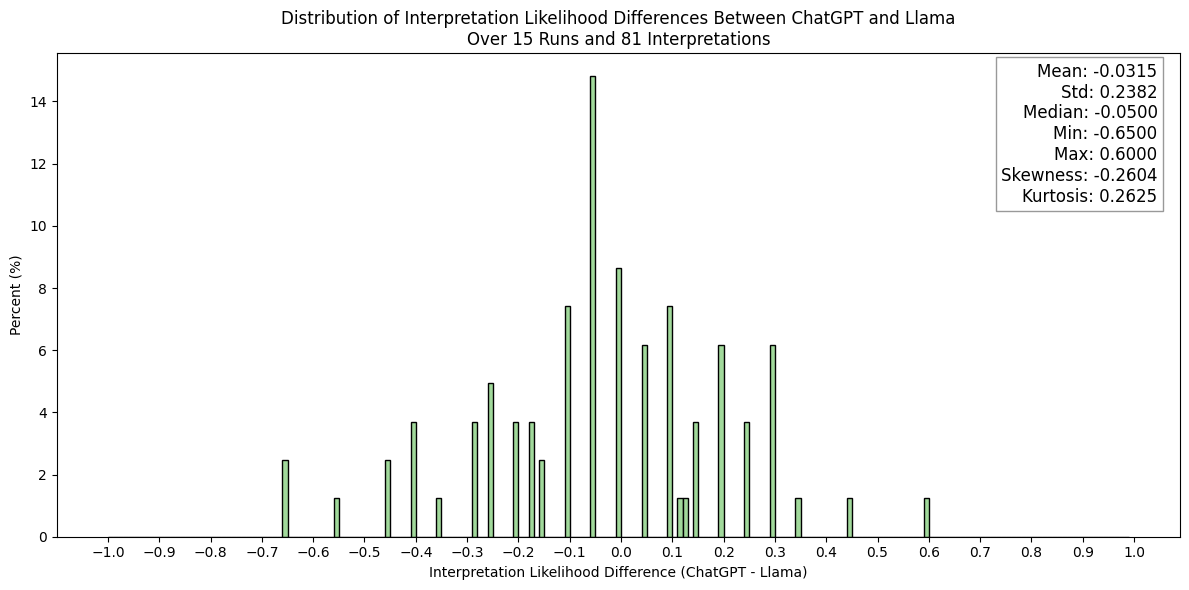

In [110]:
json_file_path = "../Data/prompt3/interpretations_llm_v1_llama1.json"
likelihood_difference_histogram(json_file_path)

In [ ]:
def phase_likelihood_difference_histogram(json_file_path):  
    """ 
    Takes in a json_file_path and outputs a histogram of all phase likelihood differences in each interpretation of each sample 
    """
     # Define bin edges for every 0.01 from -1 to 1
    # Collect all phase likelihood differences in a list
    json_file = load_json(json_file_path)
    phase_diffs = []
    for run in json_file:
        if "Synth_Conditions" in json_file[run]:
            for interpret in json_file[run]:
                if interpret != "Synth_Conditions":
                    chatgpt_phases = json_file[run][interpret].get("LLM_phases_likelihood")
                    llama_phases = json_file[run][interpret].get("LLM_phases_likelihood_llama")
                    if chatgpt_phases and llama_phases:
                        for phase in chatgpt_phases:
                            if phase in llama_phases:
                                chatgpt_val = chatgpt_phases[phase]
                                llama_val = llama_phases[phase]
                                if chatgpt_val is not None and llama_val is not None:
                                    phase_diffs.append(chatgpt_val - llama_val)
    # Calculate statistics if phase_diffs is not empty
    if phase_diffs:  # Check if list is not empty
        diffs_np = np.array(phase_diffs)
        mean = np.mean(diffs_np)
        std = np.std(diffs_np)
        median = np.median(diffs_np)
        min_val = np.min(diffs_np)
        max_val = np.max(diffs_np)
        skew = stats.skew(diffs_np)
        kurtosis = stats.kurtosis(diffs_np)

        stats_text = (
            f"Mean: {mean:.4f}\n"
            f"Std: {std:.4f}\n"
            f"Median: {median:.4f}\n"
            f"Min: {min_val:.4f}\n"
            f"Max: {max_val:.4f}\n"
            f"Skewness: {skew:.4f}\n"
            f"Kurtosis: {kurtosis:.4f}"
        )
    else:
        print("No data to compute statistics.")

    # Define bin edges for every 0.01 from -1 to 1
    bins = np.arange(-1, 1, 0.01)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.hist(phase_diffs, bins=bins, density=True, color="#a1d99b", edgecolor='black')
    ax.set_xlabel('Phase Likelihood Difference (ChatGPT - Llama)')
    ax.set_ylabel('Percent (%)')
    ax.set_title(f'Distribution of Phase Likelihood Differences Between ChatGPT and Llama\nOver {total_runs} Runs and {total_phases} Phases')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(.1))
    # Display statistics on the plot
    ax.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=12,
        va='top', ha='right',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
    )

    plt.tight_layout()
    plt.show()

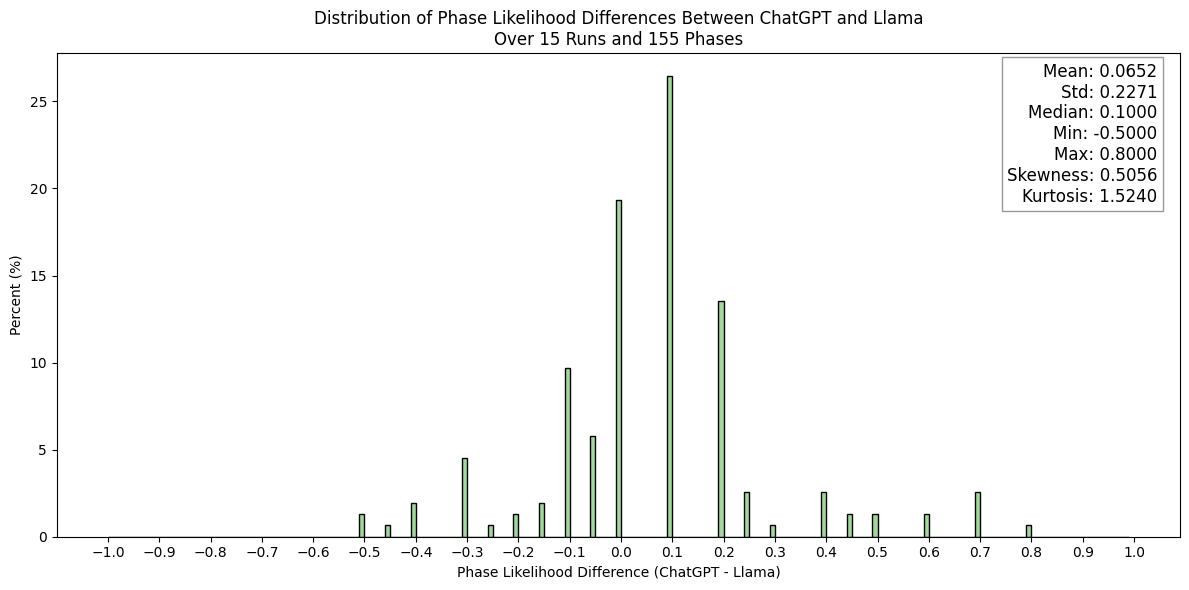

In [111]:
json_file_path = "../Data/prompt3/interpretations_llm_v1_llama1.json"
phase_likelihood_difference_histogram(json_file_path)

In [55]:
def phase_likelihood_comparison(json_file_path, sample):
    """ 
    takes a given sample and graphs out the phase likelihoods in each interpretation for all phases 
    Good for making sure phase rankings are consistent when looking at different interpretations. 
    Llama has a habit of letting the interpretation influence the phase likelihoods
    """
    # ---- Pick a range of interpretations to process ----
    start_idx = 0   # inclusive
    end_idx = 10     # exclusive (change as needed)
    # ---------------------------------------------------

    run = sample
    json_file = load_json(json_file_path)

    all_interpretations = [k for k in json_file[run] if k.startswith("I_")]
    interpretations = all_interpretations[start_idx:end_idx]

    # 1. Collect all unique phase names for the selected interpretations
    all_phases = set()
    for interpretation in interpretations:
        phase_likelihoods = json_file[run][interpretation].get("LLM_phases_likelihood_llama", {})
        for phase in phase_likelihoods:
            all_phases.add(phase)
    all_phases = sorted(all_phases)

    # 2. For each phase, collect only interpretations where phase is present
    phase_likelihood_matrix = []
    phase_interp_labels = []
    for phase in all_phases:
        likelihoods = []
        interp_labels = []
        for interp in interpretations:
            phase_likelihoods = json_file[run][interp].get("LLM_phases_likelihood_llama", {})
            value = None
            # Try both long and short keys
            if phase in phase_likelihoods:
                value = phase_likelihoods[phase]
            else:
                for k, v in phase_likelihoods.items():
                    if phase_key_to_short(k) == phase:
                        value = v
                        break
            if value is not None:
                likelihoods.append(value)
                interp_labels.append(interp)
        phase_likelihood_matrix.append(likelihoods)
        phase_interp_labels.append(interp_labels)

    # 3. Plot: one subplot per phase, x-axis = only interpretations where phase is present
    n_phases = len(all_phases)
    ncols = 2
    nrows = int(np.ceil(n_phases / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3*nrows), sharex=False)
    axes = axes.flatten()

    if n_phases == 1:
        axes = [axes]

    for i, phase in enumerate(all_phases):
        ax = axes[i]
        y = phase_likelihood_matrix[i]
        x_labels = phase_interp_labels[i]
        x = np.arange(len(x_labels))
        std = np.std(y) if len(y) > 1 else 0  # Avoid std of single value
        ax.bar(x, y, color='lightskyblue', width=.7)
        ax.set_ylabel('Likelihood')
        ax.set_title(f'Phase: {phase}\nStd: {std:.3f}', fontsize = 10)
        ax.set_ylim(0, 1.1)
        for j, val in enumerate(y):
            ax.text(j, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha='right')

    axes[-1].set_xlabel('Interpretation')
    plt.tight_layout()
    plt.show()

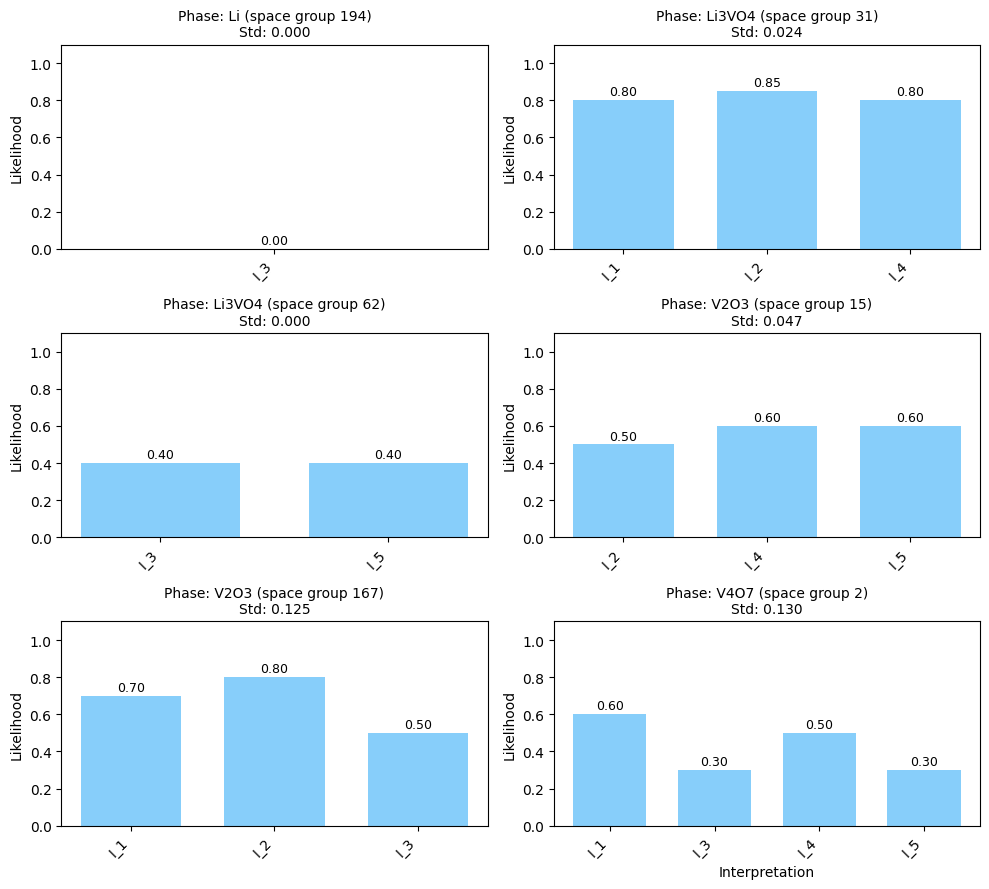

In [84]:
json_file_path = "../Data/prompt3/interpretations_llm_v3_llama1(183).json"
sample = "TRI_114"
phase_likelihood_comparison(json_file_path, sample)

In [71]:
### Interpretation likelihood and phase likelihoods for a specific run and interpretation with explanations to understand error ###
def single_interpretation_phase_likelihoods(json_file_path,sample,interpret):
    """ 
    Graphs the phase likelihoods with synthesis information for one interpretation 
    With the two file paths possible it is also easy to adapt this to compare two runs of llama 
    Some Llama responses have approximate equal instead of space group which makes it difficult to make this graph work 
    """
    run = sample
    json_file_path1 = json_file_path
    json_file_path2 = json_file_path
    json_file1 = load_json(json_file_path1)
    json_file2 = load_json(json_file_path2)
    llama_interpret = json_file1[run][interpret]["LLM_interpretation_likelihood_llama"]
    gpt_interpret = json_file2[run][interpret]["LLM_interpretation_likelihood"]
    diff = round(gpt_interpret - llama_interpret,2)
    labels = []
    run_interpret1 = json_file1[run][interpret]
    run_interpret2 = json_file2[run][interpret]
    gpt_phase_likelihood = run_interpret1["LLM_phases_likelihood"]
    llama_phase_likelihood = run_interpret2["LLM_phases_likelihood_llama"]
    labels_only = list(llama_phase_likelihood.keys())
    for i in range(len(labels_only)):
        wf = run_interpret1["weight_fraction"]
        labels.append(f"{phase_key_to_short(labels_only[i])} {round(wf[i],2)}%")

    gpt_likelihoods = list(gpt_phase_likelihood.values())
    llama_likelihoods = list(llama_phase_likelihood.values())
    synth = json_file1[run]["Synth_Conditions"]
    if "Precursor 3" in synth:
        input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'
    else:
        input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}'

    x = np.arange(len(labels))
    width = 0.3

    plt.figure(figsize=(7,5))

    plt.bar(x-width/2,gpt_likelihoods,width, label='Chat GPT', color = "darkorange")
    plt.bar(x+width/2,llama_likelihoods,width,label='Llama', color = "dodgerblue")

    plt.title(f'Phase Likelihoods for {run} {interpret}\nInterpretation Diff: {diff} (GPT:{gpt_interpret} Llama:{llama_interpret})\n Precursors: {input_phases}', fontsize=8)
    plt.ylabel('Likelihood (0-1)')
    plt.xlabel('Phase')
    labels = [phase_key_to_short(label) for label in labels]
    plt.xticks(x, labels, rotation=0, ha='center')
    plt.ylim(0, 1.2)

    for j, val in enumerate(gpt_likelihoods):
        plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    for j, val in enumerate(llama_likelihoods):
        plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
    plt.legend()
    plt.tight_layout()

    phase_exp1 = run_interpret1["LLM_phases_explanation"]
    phase_exp2 = run_interpret2["LLM_phases_explanation_llama"]
    for label in labels_only:
        print(phase_key_to_short(label))
        print(f'Chat GPT: "{phase_exp1[label]}"')
        print(f'Llama: "{phase_exp2[label]}"')
    print("")
    print(f'Chat GPT Interpretation: "{run_interpret1["LLM_interpretation_explanation"]}"')
    print(f'Llama Interpretation: "{run_interpret1["LLM_interpretation_explanation_llama"]}"')
        
    plt.show()



In [115]:
json_file_path = "../Data/prompt3/interpretations_llm_v1_llama1.json"
sample = "TRI_84"
interpret = "I_1"
single_interpretation_phase_likelihoods(json_file_path,sample,interpret)

IndexError: list index out of range

In [63]:
def graph_largest_diff_interpretations(json_file_path,n=5):    
    """ 
    Returns graphs for the top n interpretations with the largest difference in interpretation likelihood between chat GPT and Llama 
    For each interpretation it graphs out the phase liklihoods for each phase in the interpretation 
    Because Llama had a habit of including approximate equal instead of space group in its response, this has messed up some of the formatting
    """
    json_file = load_json(json_file_path)
    interp = []
    runs = []
    chatgpt_vals = []
    llama_vals = []
    diff = []


    ### creates a chart with the interpretations with the highest difference between chat GPT and Llama

    def n_farthest_from_zero(values, n): # Returns a list of indices for the largest values from a list
        # Create a list of (index, abs(value)) pairs
        indexed_abs = [(i, abs(val)) for i, val in enumerate(values)]

        # Sort by absolute value in descending order and take the top n
        top_n = sorted(indexed_abs, key=lambda x: x[1], reverse=True)[:n]

        # Extract the original indices
        return [i for i, _ in top_n]
    def n_closest_to_zero(values, n): # Returns a list of indices for the largest values from a list
        # Create a list of (index, abs(value)) pairs
        indexed_abs = [(i, abs(val)) for i, val in enumerate(values)]

        # Sort by absolute value in descending order and take the top n
        m = len(values)-n
        top_n = sorted(indexed_abs, key=lambda x: x[1], reverse=True)[m:]

        # Extract the original indices
        return [i for i, _ in top_n]

    for run in json_file: 
        if "Synth_Conditions" in json_file[run]:
            for interpret in json_file[run]:
                if interpret != "Synth_Conditions":
                    runs.append(run)
                    interp.append(interpret)
                    chatgpt_val = json_file[run][interpret].get("LLM_interpretation_likelihood")
                    llama_val = json_file[run][interpret].get("LLM_interpretation_likelihood_llama")
                    chatgpt_vals.append(chatgpt_val)
                    llama_vals.append(llama_val)
                    diff.append(chatgpt_val - llama_val)
    indices = n_farthest_from_zero(diff,n)

    interp1 = []
    runs1 = []
    chatgpt_vals1 = []
    llama_vals1 = []
    diff1 = []

    for i in indices: 
        interp1.append(interp[i])
        runs1.append(runs[i])
        chatgpt_vals1.append(chatgpt_vals[i])
        llama_vals1.append(llama_vals[i])
        diff1.append(diff[i])
        
    for i in range(len(interp1)):
        run = runs1[i]
        interpret = interp1[i]
        llama_interpret = llama_vals1[i]
        gpt_interpret = chatgpt_vals1[i]
        diff = round(diff1[i],2)
        run_interpret = json_file[run][interpret]
        gpt_phase_likelihood = run_interpret["LLM_phases_likelihood"]
        llama_phase_likelihood = run_interpret["LLM_phases_likelihood_llama"]
        labels = list(llama_phase_likelihood.keys())
        gpt_likelihoods = list(gpt_phase_likelihood.values())
        llama_likelihoods = list(llama_phase_likelihood.values())
        synth = json_file[run]["Synth_Conditions"]
        if "Precursor 3" in synth:
            input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}, {synth["Precursor 3"]}'
        else:
            input_phases = f'{synth["Precursor 1"]}, {synth["Precursor 2"]}'

        x = np.arange(len(labels))
        width = 0.3

        plt.figure(figsize=(7,5))

        plt.bar(x-width/2,gpt_likelihoods,width, label='Chat GPT', color = "darkorange")
        plt.bar(x+width/2,llama_likelihoods,width,label='Llama', color = "dodgerblue")

        plt.title(f'Phase Likelihoods for {run} {interpret}\nInterpretation Diff: {diff} (GPT:{gpt_interpret} Llama:{llama_interpret})\n Precursors: {input_phases}', fontsize=8)
        plt.ylabel('Likelihood (0-1)')
        plt.xlabel('Phase')
        labels = [phase_key_to_short(label) for label in labels]
        plt.xticks(x, labels, rotation=0, ha='center')
        plt.ylim(0, 1.2)
        
        for j, val in enumerate(gpt_likelihoods):
            plt.text(j-width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
        for j, val in enumerate(llama_likelihoods):
            plt.text(j+width/2, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9, rotation=0, clip_on=True)
        plt.legend()
        plt.tight_layout()
        plt.show


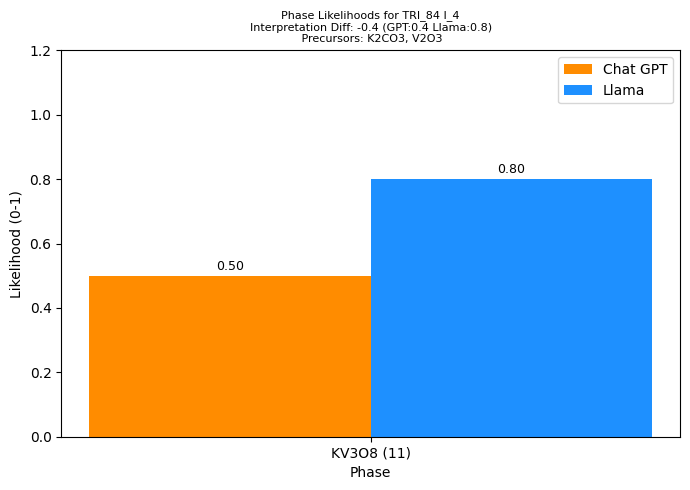

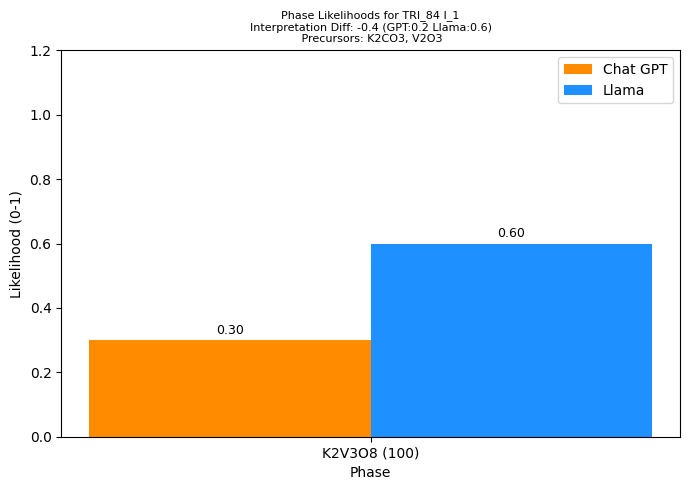

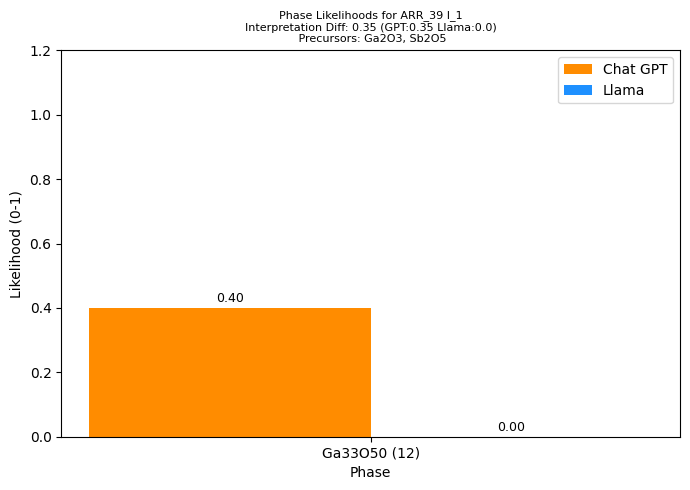

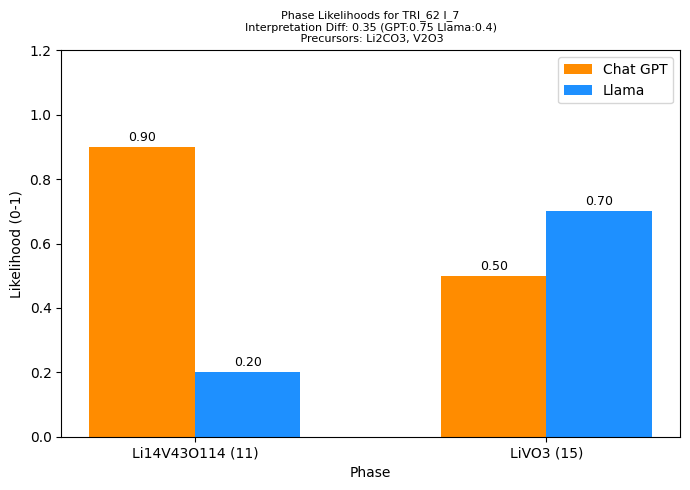

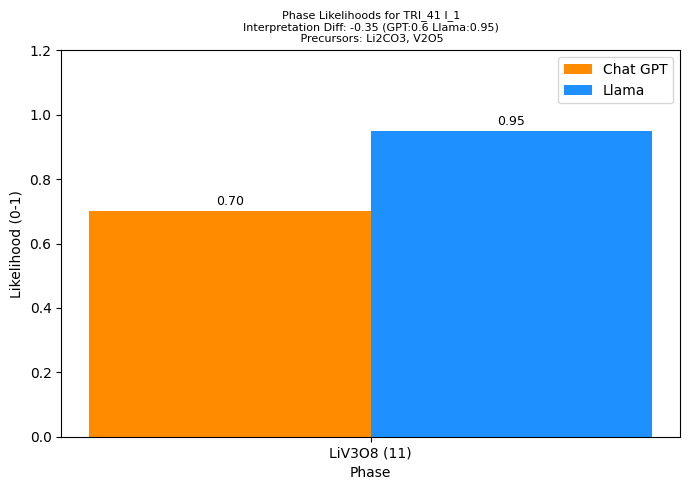

In [85]:
json_file_path = "../Data/prompt3/interpretations_llm_v3_llama1(183).json"
graph_largest_diff_interpretations(json_file_path)

In [76]:
def plot_all_largeDiff(json_file,num=0.2):
    """ 
    Plots the interpretations from all samples, flags the darker blue interpretations that have a large difference in interpretation likelihoods
    num: the amount of difference to flag interpretations
    """
    large_diff_all = []

    num = 0.2

    for sample in json_file:
        #print("hello")
        large_diff = 0
        for interpret in json_file[sample]:
            if interpret not in ["Synth_Conditions"]:
                phases = list(json_file[sample][interpret]["LLM_phases_likelihood_llama"].keys())
                weightfractions = json_file[sample][interpret]["weight_fraction"]
                #if len(phases) == len(weightfractions):
                gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                score_diff = gpt_score - llama_score
                if abs(score_diff) > num +0.005:
                    large_diff += 1
        sample_tot = (sample,large_diff)
        large_diff_all.append(sample_tot)

    sorted_list = sorted(large_diff_all, key=lambda x: x[1])

    #print(sorted_list)
    def plot_named_bar_graph(data, xlabel="Sample", ylabel="Number of Interpretations"):
        """
        Plots the how many interpretations have low error when comparing Chat GPT and Llama 
        Usefull for getting a rough idea for how closely they match
        also averages out the percentage of high difference interpretations 
        """
        labels = [item[0] for item in data]
        values = [item[1] for item in data]
        num_dict = {}
        #print(labels)
        for sample in labels:
            num_interpretations = 0
            if sample in json_file:
                for interpret in json_file[sample]:
                    if interpret not in ["Synth_Conditions"]:
                        phases = list(json_file[sample][interpret]["LLM_phases_likelihood_llama"].keys())
                        weightfractions = json_file[sample][interpret]["weight_fraction"]
                        #if len(phases) == len(weightfractions):
                        num_interpretations += 1
            num_dict[sample] = num_interpretations
        #print(num_dict)
        labels = [f"{label} ({num_dict[label]})" for label in labels]
        plt.figure(figsize=(10, 5))
        second_bar = list(num_dict.values())
        plt.bar(labels, second_bar, color="#92c3e4", label = "All Interpretations")
        bars = plt.bar(labels, values, color="#226a9e", label = f"Interpretations with > {num} Difference")
        
        title= f"Number of Interpretations with Likelihood Difference > {num} Between Chat GPT and Llama\nTotal Samples: {len(labels)}"
        # Add value labels on top of each bar
        percentage_high_error = []
        for bar, value, tot in zip(bars, values,second_bar):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                tot + 0.1,
                f"{value}/{tot}",
                ha='center',
                va='bottom',
                fontsize=9
            )
            percentage_high_error.append(value/tot*100)
        average = round(np.average(percentage_high_error),2)
        # Add text box in top-left corner
        plt.text(0.01, 0.95, f'Average Percent of\nInterpretations with > {num} Error: {average:.1f}%', transform=plt.gca().transAxes,
            ha='left', va='top', fontsize=plt.rcParams['legend.fontsize'],
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='lightgrey', alpha=0.8))

        y_limit = max(second_bar)
        plt.ylim(0, y_limit + 4)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title="Legend")
        plt.tight_layout()
        plt.show()

    plot_named_bar_graph(large_diff_all)

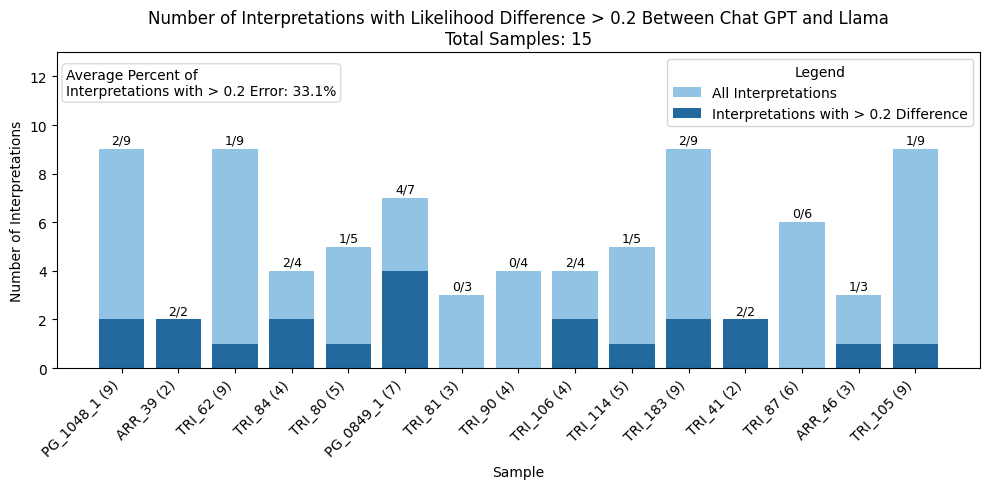

In [77]:
json_file_path = "../Data/prompt3/interpretations_llm_v3_llama3(185).json"
json_file = load_json(json_file_path)
plot_all_largeDiff(json_file)

In [80]:
def plot_all_largeDiff_multiple(json_files,num=0.2):

    """ 
    Creates a graph like the single plot above, but with subplots for every run and the statistics for each run and the average
    """
    # num threshold for likelihood difference
    n_files = len(json_files)
    all_averages = []
    # create plot
    fig, axes = plt.subplots(nrows=n_files//2, ncols=2, figsize=(13, 4*n_files//2), squeeze=True)
    axes = axes.flatten()

    # format files
    for i, (json_file, ax) in enumerate(zip(json_files, axes)):
        large_diff_all = []
    # get ratings and total all large differences
        for sample in json_file:
            large_diff = 0
            for interpret in json_file[sample]: 
                if interpret != "Synth_Conditions":
                    gpt_score = json_file[sample][interpret]["LLM_interpretation_likelihood"]
                    llama_score = json_file[sample][interpret]["LLM_interpretation_likelihood_llama"]
                    score_diff = gpt_score - llama_score
                    if abs(score_diff) > num + 0.005:
                        large_diff += 1
            sample_tot = (sample, large_diff)
            large_diff_all.append(sample_tot)


        unsorted_list = large_diff_all
        labels = [item[0] for item in unsorted_list]
        values = [item[1] for item in unsorted_list]

        num_dict = {}
        for sample in labels:
            num_interpretations = 0
            if sample in json_file:
                for interpret in json_file[sample]:
                    if interpret != "Synth_Conditions":
                        num_interpretations += 1
            num_dict[sample] = num_interpretations

        all_counts = [num_dict[sample] for sample in labels]
        labels_with_count = [f"{label} ({num_dict[label]})" for label in labels]

        bars_all = ax.bar(labels_with_count, all_counts, color="#92c3e4", label="All Interpretations")
        bars_diff = ax.bar(labels_with_count, values, color="#226a9e", label=f"> {num} Difference")

        # Add value labels
        percentage_high_error = []
        for bar, val, tot in zip(bars_diff, values, all_counts):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                tot + 0.1,
                f"{val}/{tot}",
                ha='center',
                va='bottom',
                fontsize=9
            )
            percentage_high_error.append(val / tot * 100)

        average = round(np.average(percentage_high_error), 2)
        all_averages.append(average)
        # Add subplot-specific title
        ax.set_title(f"Run {i+1}")
        ax.set_ylim(0, max(all_counts) + 5)
        ax.set_xticks(range(len(labels_with_count)))
        ax.set_xticklabels(labels_with_count, rotation=45, ha='right')
        ax.set_ylabel("Number of Interpretations")
        ax.legend()

        # Add average annotation
        ax.text(
            0.02, 0.95,
            f'Avg % with > {num} diff:\n{average:.1f}%',
            transform=ax.transAxes,
            ha='left', va='top',
            fontsize=plt.rcParams['legend.fontsize'],
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='lightgrey', alpha=0.8)
        )

    fig.suptitle(f"Interpretation Likelihood Differences Between ChatGPT and Llama\nTotal Samples Per Run: {len(labels)}", fontsize=14, fontweight="bold")
    average_AllRuns = round(np.average(all_averages),1)
    fig.text(
        0.5, 0.92,  # x=0.5 centers it, y controls vertical position
        f"Avg % with > {num} difference (All Runs): {average_AllRuns}%",
        ha='center', va='top',
        fontsize=12
    )
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


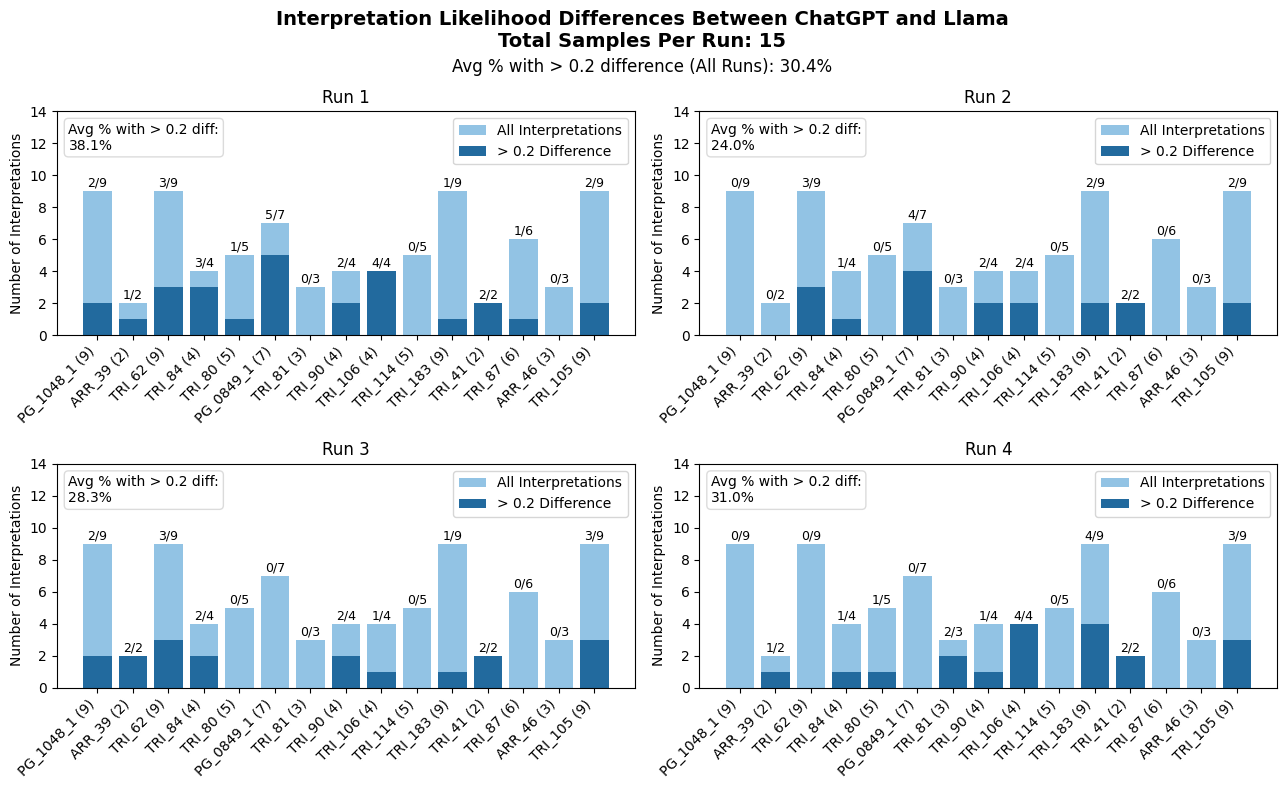

In [81]:
json_file_path1 = "../Data/prompt3/interpretations_llm_v1_llama1.json"
json_file_path2 = "../Data/prompt3/interpretations_llm_v1_llama2.json"
json_file_path3 = "../Data/prompt3/interpretations_llm_v1_llama3.json"
json_file_path4 = "../Data/prompt3/interpretations_llm_v1_llama5.json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
json_file3 = load_json(json_file_path3)
json_file4 = load_json(json_file_path4)
plot_all_largeDiff_multiple([json_file1,json_file2,json_file3,json_file4],num=0.2)

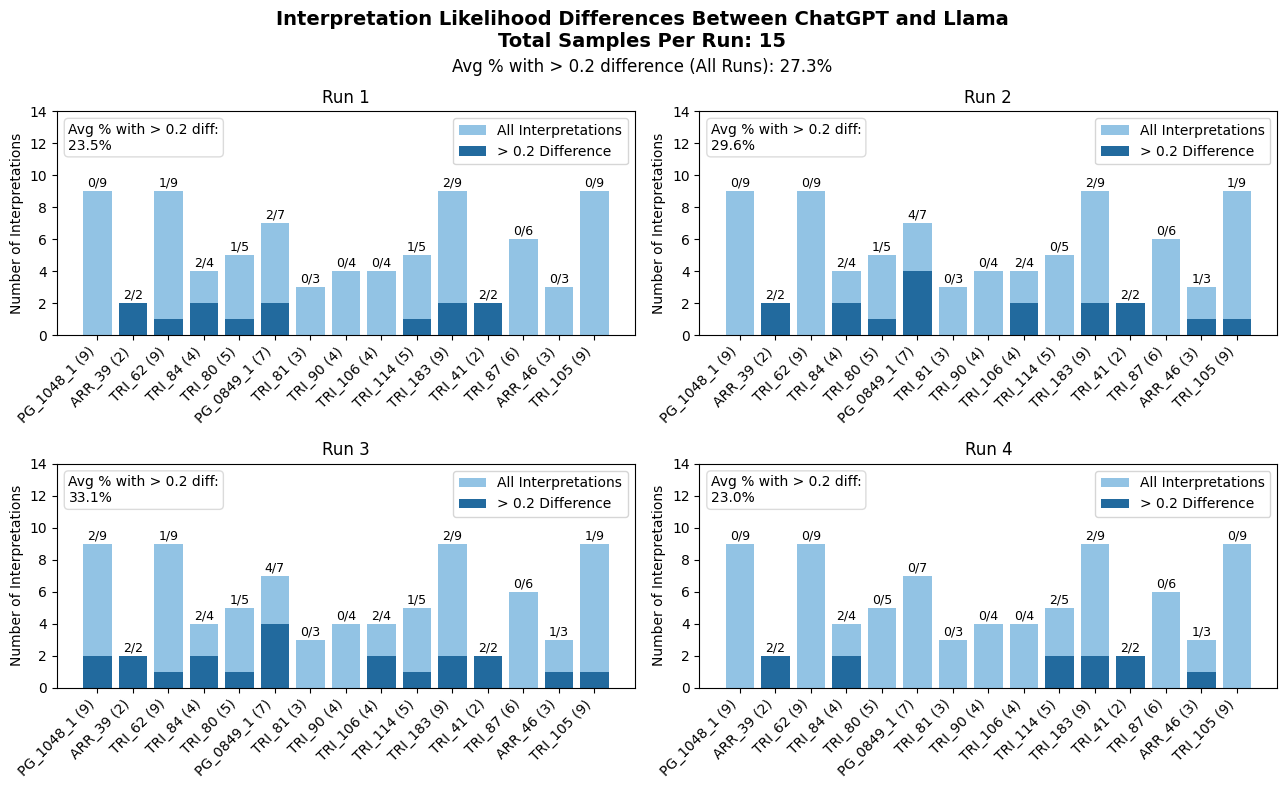

In [113]:
json_file_path1 = "../Data/prompt3/interpretations_llm_v3_llama1(183).json"
json_file_path2 = "../Data/prompt3/interpretations_llm_v3_llama2(184).json"
json_file_path3 = "../Data/prompt3/interpretations_llm_v3_llama3(185).json"
json_file_path4 = "../Data/prompt3/interpretations_llm_v3_llama4(186).json"
json_file1 = load_json(json_file_path1)
json_file2 = load_json(json_file_path2)
json_file3 = load_json(json_file_path3)
json_file4 = load_json(json_file_path4)
plot_all_largeDiff_multiple([json_file1,json_file2,json_file3,json_file4],num=0.2)